- 필요한 라이브러리 다운로드

In [ ]:
pip install pydot
conda install graphviz

In [23]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pydicom as dcm
from pathlib import Path
import os
from tqdm.notebook import tqdm
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Layer, Convolution2D, Dense, RandomRotation, RandomFlip, Resizing, Rescaling
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Input, ReLU, AveragePooling2D, Activation, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import losses, optimizers
from keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.python.client import device_lib
import graphviz, pydot

- GPU 여부 체크

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2 Physical GPUs, 2 Logical GPUs


- CUDA 버전 및 GPU 메모리 사용량 체크

In [3]:
! nvidia-smi

Mon Nov 13 15:41:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.89.02    Driver Version: 525.89.02    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:AF:00.0 Off |                  N/A |
| 30%   39C    P2    65W / 250W |    319MiB / 11264MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:D8:00.0 Off |                  N/A |
| 31%   

1. - Driver Version: 현재 설치되어 사용하고 있는 nvidia GPU의 driver version.

2. - CUDA Version: 현재 사용하고 있는 driver와 호환이 잘 되는 CUDA의 version, 이는 추천해주는 것뿐이라서 현재 설치되어 사용하고 있는 CUDA의 version을 이야기하는 것이 아님. 설치되어 사용하고 있는 CUDA 의 version은 '! nvcc --version' 를 통해 확인.

3. - GPU Fan: 현재 설치되어 있는 GPU의 번호와 fan이 장착되어 있는 GPU의 fan 성능을 %로 나타낸 것임 (Tesla 계열의 GPU는 fan이 없어 N/A로 표기).

4.
  - Name: GPU의 model명.
  - Temp: 현재 GPU 온도. 보통 70도에서 80도 사이가 적당한 온도임.
  - Perf: Performance의 약자로 P0부터 P12까지 존재함. 숫자가 작아질수록 GPU의 performance가 좋은 상태를 나타냄.
  - Persistence-M: Persistence-Mode로 on-mode와 off-mode가 존재한다. 기본적으로 default mode는 off이며, on-mode가 되면 nvidia 커널 모듈이 지정된 GPU에 대해서 항상 활성화 상태가 되도록 강제할 수 있음.
  - Pwr:Usage/Cap: GPU의 현재 전력의 사용량과 최대 용량을 나타냄.

5.
  - Bus-ID: Main board의 PCI slot에 부여된 Bus-ID.
  - Disp.A: 화면 출력을 GPU card로 하는 경우 on 상태로 변경이 됨.
  - Memory-Usage: 현재 사용하고 있는 GPU의 memory와 GPU의 총 memory 용량.

6.
  - Volatile Uncorr.ECC: 데이터 저장 장치나 메모리 시스템에서 발생하는 에러를 검출하고 수정하는 기능. default 는 off 상태임.
  - GPU-Util: GPU의 현재 성능을 나타낸 것으로 100%의 성능 중 얼마만큼 사용하고 있는지를 나타내고 있다. 즉, 현재 해당 GPU의 사용량을 나타낸 것이다.
  - Compute M: 공유접근에 대한 설정 모드로 Default는 0임. 1은 exclusive thread mode, 2은 prohibited mode, 3은 exclusive process mode를 의미함.
  - MIG M: NVIDIA GPU를 slice하는 기능으로, Multi-Instance GPU의 약자임. CUDA application을 실행시 최대 7개의 개별 GPU instance로 안전하게 분할하여 여러 사용자에게 별도의 GPU를 제공하여 작업을 가속화하는데 도움을 줌.

In [4]:
print(tf.__version__)

2.8.0


In [5]:
!cat /usr/local/cuda/include/cudnn_version.h | grep CUDNN_MAJOR -A 2

#define CUDNN_MAJOR 8
#define CUDNN_MINOR 1
#define CUDNN_PATCHLEVEL 0
--
#define CUDNN_VERSION (CUDNN_MAJOR * 1000 + CUDNN_MINOR * 100 + CUDNN_PATCHLEVEL)

#endif /* CUDNN_VERSION_H */


! nvcc --version

- 훈련하기 위한 RSNA 폐렴 데이터셋 불러오기

In [6]:
train_class = pd.read_csv('stage_2_detailed_class_info.csv')
train_labels = pd.read_csv('stage_2_train_labels.csv')
train_meta = pd.concat([train_labels, train_class.drop(columns=['patientId'])], axis=1)

- dicom 파일 예시

In [7]:
dcm.read_file('stage_2_train_images/000db696-cf54-4385-b10b-6b16fbb3f985.dcm')

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.4475.1517874307.936345
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.4475.1517874307.936345
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time        

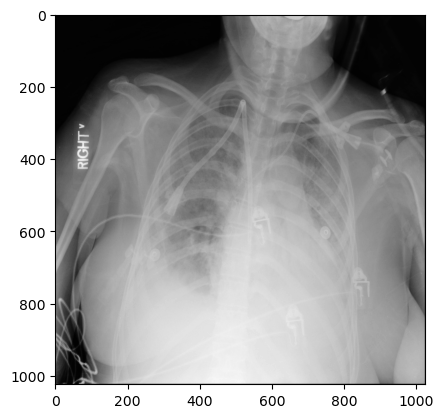

In [8]:
img_1ch =dcm.read_file('stage_2_train_images/000db696-cf54-4385-b10b-6b16fbb3f985.dcm').pixel_array
plt.imshow(img_1ch, cmap='gray')

- dicom 파일 불러오기 위한 함수 정의
- 이미지 크기를 1024X1024 에서 128X128로 축소

In [9]:
%%time

def get_image(dcm_file):
    ADJUSTED_IMAGE_SIZE = 128
    dcm_data = dcm.read_file(dcm_file)
    img = dcm_data.pixel_array
    img = np.stack((img,) * 3, -1)

    img = np.array(img).astype(np.uint8)
    res = cv2.resize(img,(ADJUSTED_IMAGE_SIZE,ADJUSTED_IMAGE_SIZE), interpolation = cv2.INTER_LINEAR)
    return res

def read_train(rowData):
    imageList = []
    for index, row in tqdm(rowData.iterrows()):
        patientId = row.patientId
        dcm_file = 'stage_2_train_images/'+'{}.dcm'.format(patientId)
        imageList.append(get_image(dcm_file))

    return np.array(imageList)

train_images = read_train(train_labels)
print(train_images.shape)

0it [00:00, ?it/s]

(30227, 128, 128, 3)
CPU times: user 3min 56s, sys: 3.96 s, total: 4min
Wall time: 3min 59s


- train 데이터셋과 라벨 확인

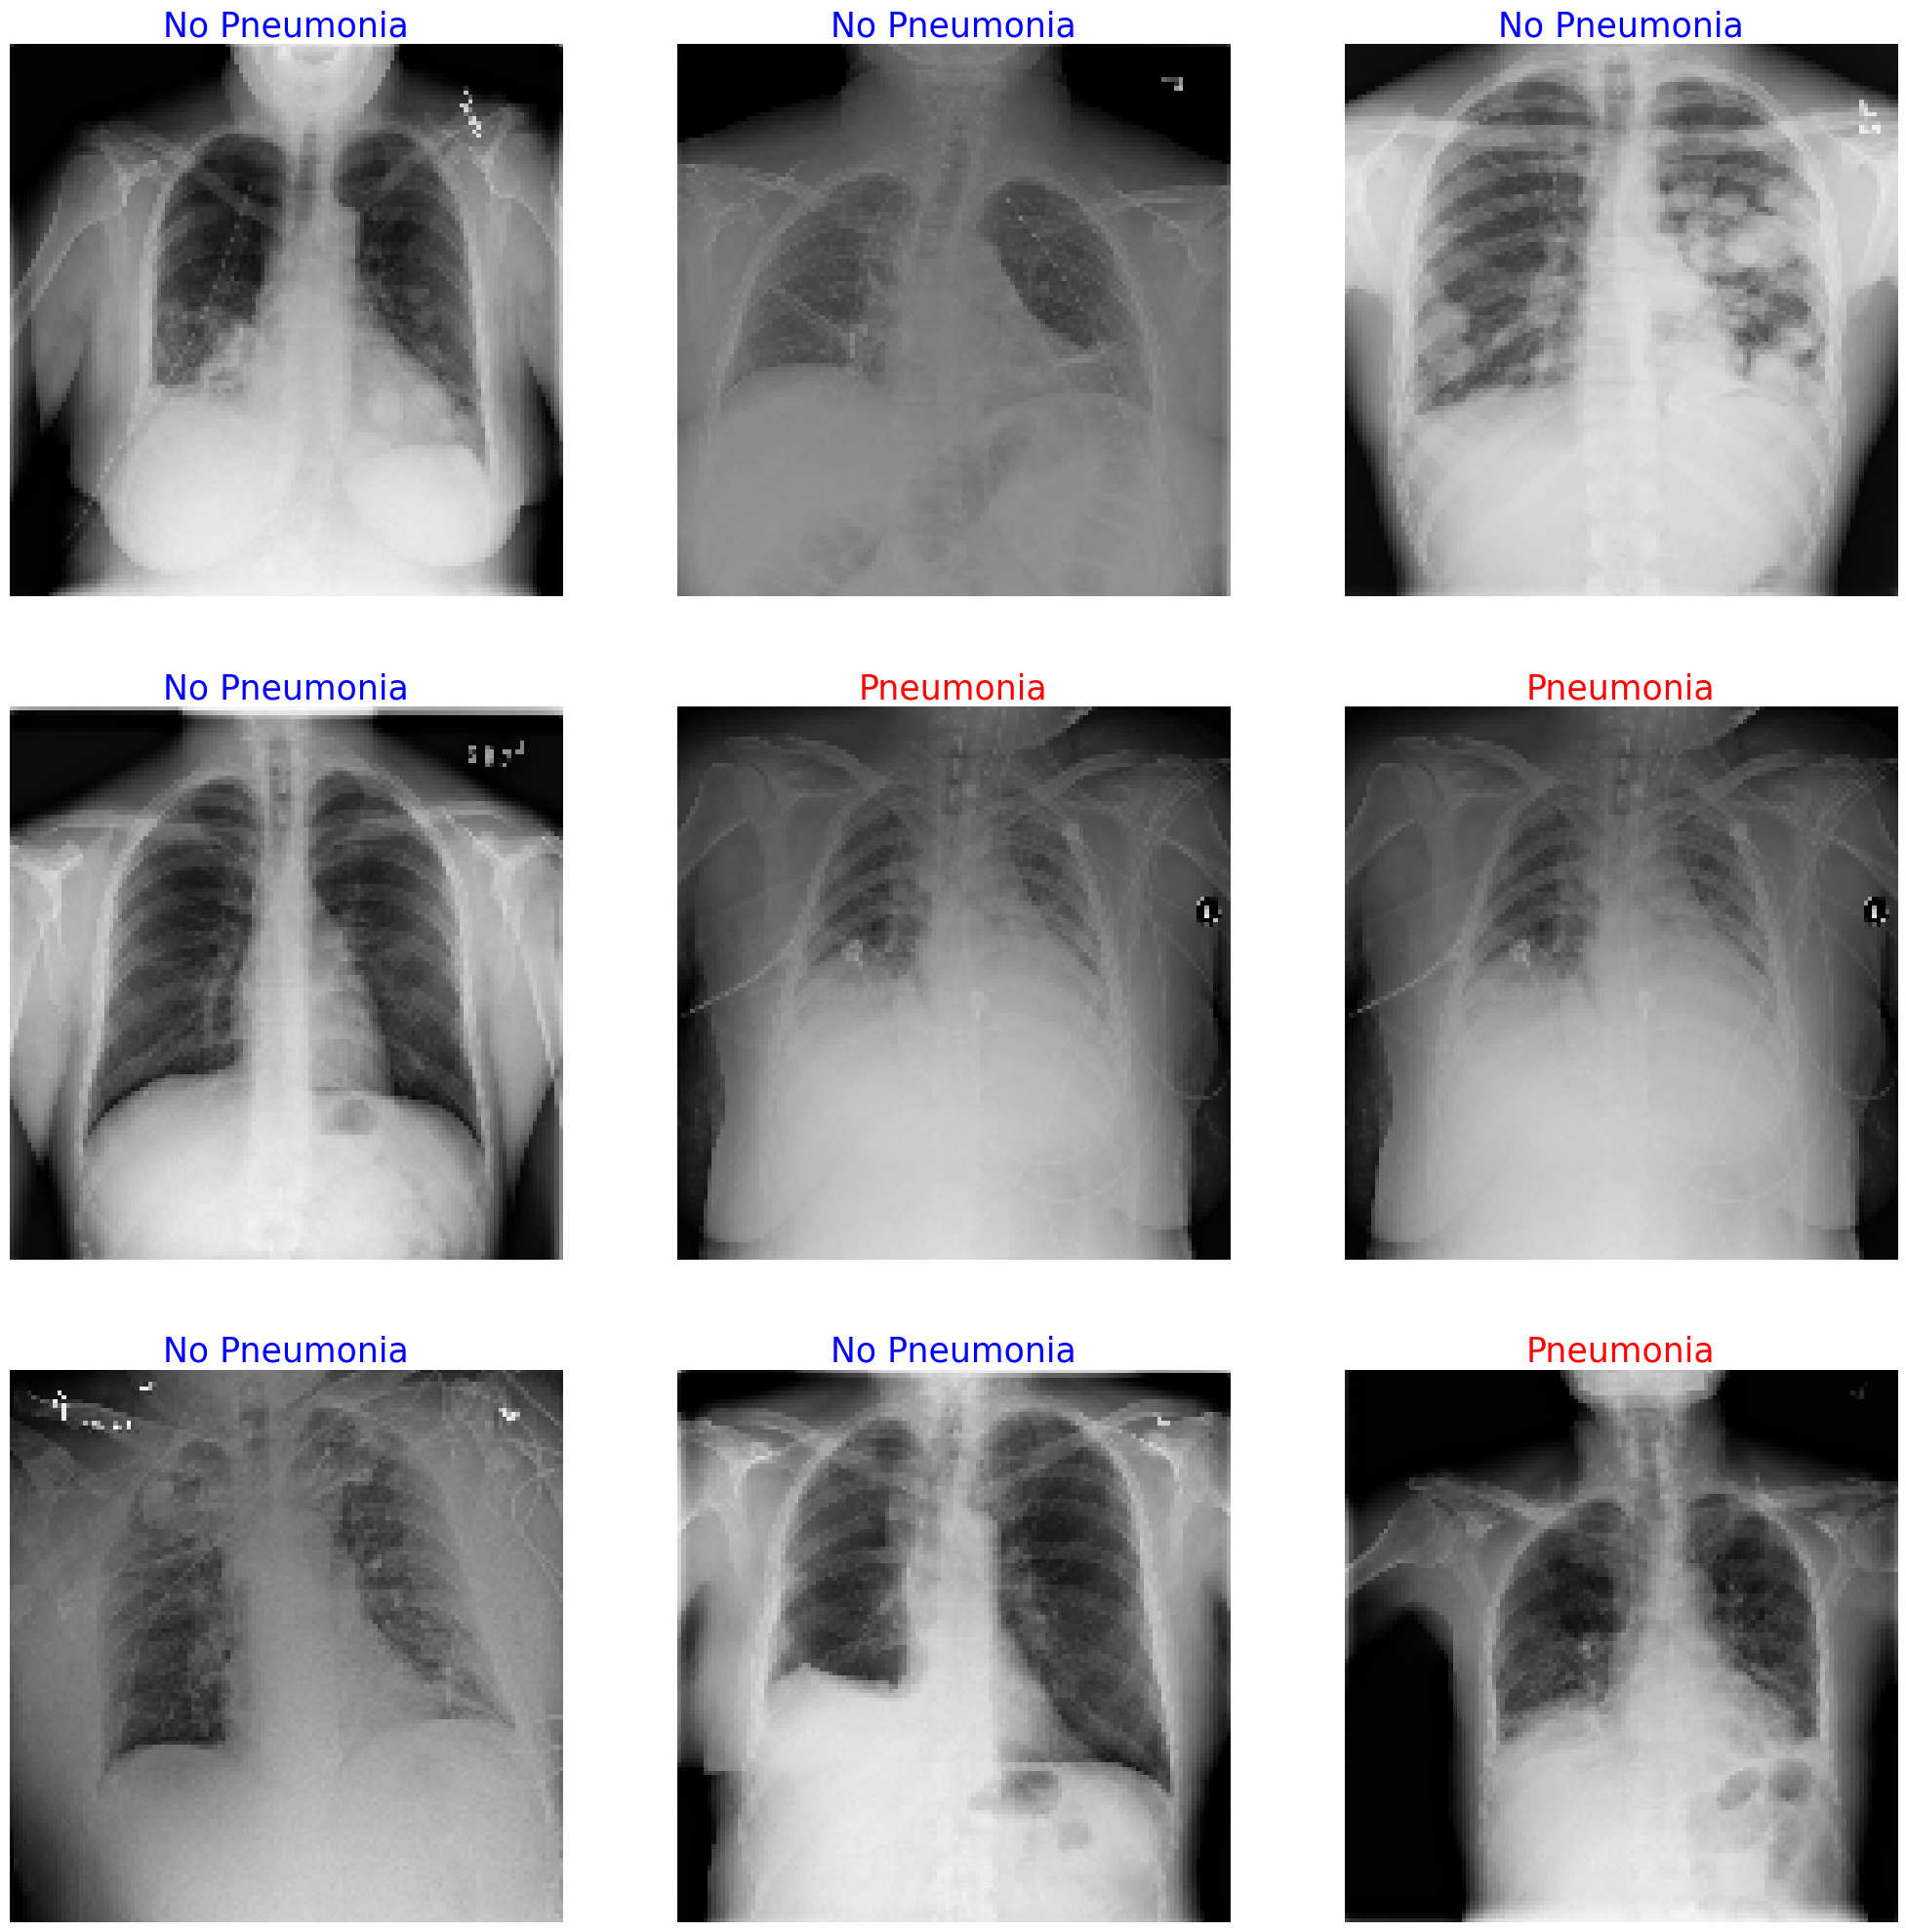

In [10]:
plt.figure(figsize=(25,25)) # 
for i, image in enumerate(train_images[:9]):

    plt.subplot(3,3,i+1)
    plt.imshow(image)
    if train_labels.loc[i]["Target"]:
        plt.title("Pneumonia", color="red", fontsize=25)
    else:
        plt.title("No Pneumonia", color="blue", fontsize=25)
    plt.axis('off')
plt.show()

- train 데이터셋과 test 데이터셋으로 분류

In [31]:
train_images.shape

(30227, 128, 128, 3)

In [11]:
y = pd.get_dummies(train_labels["Target"]).values
random_state = 42

X_train, X_test, y_train, y_test = train_test_split(train_images, y, test_size=0.2, random_state=random_state, stratify=y)

- 모델 평가를 위한 함수 정의
- 평가는 recall, precision, f1 score로 시행

In [12]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# CNN 모델 구축을 위한 함수 정의
### CNN (Convolutional Neural Network) 
- 합성곱층 (convolutional layer) = CNN, NLP 에서 주로 사용
- (1) 합성곱 연산은 내적 계산으로 이루어지며, 데이터의 패턴 특징 파악에 중요함
- (2) 가중치와 편향이 모델 훈련에 사용됨
- (3) 공간 구조를 유지한 채 학습이 이루어짐
- (4) 커널들을 거쳐 이미지 학습을 위한 특성 맵 (feature map)이 만들어짐 

- CNN 모델 구축을 위한 함수 정의
- 128 이미지 크기를 128x128 픽셀로 조정
- 데이터 입력형태 정의 : input_shape = 가로x세로x채널 [가로 및 세로 길이=ADJUSTED_IMAGE_SIZE, 채널=3 (RGB)]
- RandomRotation(factor=0.15) 등을 통한 데이터 증강은 모델의 일반화 향상, overfitting 과적합 방지
- Conv2D(a,(b,b),  input_shape=input_shape) = 2D 컨볼루션 레이어 , 2차원 형태 a개의 filter, bxb 커넬 크기로 이미지 스캔, input_shape 형태로 이미지 저장

### ReLU (Rectified Linear Unit) 함수
- 활성화 함수 중 하나로, 시그모이드의 기울기 소실 문제를 해결하기 위해 제안된 함수임.
- ReLU는 입력값이 양수인 경우 그대로 반환, 음수인 경우에는 0으로 만드는 비선형 활성화 함수임. 신경망의 비선형성을 도입하고 특징 맵의 비선형 특성을 향상시키는 데 사용되며, 시그모이드 함수의 출력 신속함을 보완.
- 이미지 분류 모델의 은닉층에 많이 사용하며, 시그모이드 함수는 층이 많을수록 활성화 함수의 양쪽 끝에서 변화가 작기 때문에 학습이 어려워지게 됨.

### 용어 정리
- filter : (뉴런 = 필터 = 커널) 합성곱 신경망에서의 뉴런 명칭
- Sequential() : keras 언어에서 인공신경망 레이어를 쌓는 코드
- RandomRotation() : 이미지 회전의 최대 각도, 데이터 증강의 한 방법
- Rescaling() : 이미지 정규화 
- convolution : 입력 데이터의 커널 값에 따라 가중치를 곱함
- feature map : 합성곱 계산을 통해 얻은 출력을 나타내는 용어 ex) (4x4) >> (2x2) 
- Conv2D = 2D convolutional layer
- Activation('relu') : 렐루 함수
- pooling : 합성곱 층에서 특성 맵의 가로 세로를 줄이는 역할, 특성 맵의 개수는 줄이지 않음, 가중치가 없는 대신 특성 맵에서 최댓값이나 평균값 선택
- MaxPooling() : 맵의 크기를 줄여, 주어진 크기 내에서 가장 큰 값을 선택하여 특징 맵을 다운샘플링
- AveragePooling() : 맵의 크기를 줄여, 주어진 크기 내의 평균 값을 선택하여 특징 맵을 다운샘플링
- Dropout : overfitting 방지, 특정 뉴런의 랜덤 비활성화
- softmax : 합이 1이 되는 소프트맥스 함수 출력값
- epoch : 훈련 세트를 한번 모두 사용하는 과정
- Flatten() : 2차원 데이터를 fully connected layer로 전달하기 위해 1차원 데이터로 구조를 바꿈
- Dense() : fully connected layer를 구현
- categorical crossentropy : 학습에 활용하는 손실함수 중 하나로, 엔트로피 오차를 활용하여 손실을 계산함. 이진 및 다중분류에서 사용할 수 있음
- optimizer : 손실함수의 최소값을 찾기 위해 활용하는 최적화 알고리즘. 데이터 전체를 사용하는 gradient descent, 하나의 훈련데이터만 활용하는 stochastic gradient descent, mini batch를 활용하는 mini-batch gradient descent 등이 있음
- adam : optimzier 종류 중 하나로 RMSprop 과 momentum 장점을 활용하는 방법임
- callbacks : 케라스에서 훈련 과정 중간에 어떤 작업을 수행할 수 있게 하는 객체로 모델의 상태와 성능 정보에 접근하여 훈련중지, 모델 저장, 가중치 적재 등을 처리. 모델 체크포인트 저장, 조기종료, 하이퍼파라미터 값 동적 조절, 업데이트 시 시각화 등이 있음

### model 1 (convolution 1회)

In [33]:
ADJUSTED_IMAGE_SIZE = 128
input_shape = (ADJUSTED_IMAGE_SIZE, ADJUSTED_IMAGE_SIZE, 3)
num_classes = y_train.shape[1]

model = Sequential()
model.add(RandomRotation(factor=0.15))
model.add(Rescaling(1/255))
model.add(Conv2D(32, (3, 3), input_shape=input_shape)) # (3, 3) - conv kernel

model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0005),
              metrics=['accuracy'])
with tf.device("/device:GPU:0"):
    history = model.fit(X_train,y_train,epochs = 50,validation_data = (X_test,y_test),batch_size = 8,
                        callbacks=[EarlyStopping(monitor = "val_loss", patience = 10, restore_best_weights = True),
                        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')])

fcl_loss, fcl_accuracy = model.evaluate(X_test, y_test, verbose=1) # , fcl_f1
print('Test loss:', fcl_loss)
print('Test accuracy:', fcl_accuracy)
# print('Test F1:', fcl_f1)

df = pd.DataFrame({"pred": np.argmax(model.predict(X_test), axis=1), "true": np.argmax(y_test, axis=1)})
print(classification_report(df["true"], df["pred"]))

Epoch 1/50
3023/3023 [==============================] - 20s 7ms/step - loss: 0.5805 - accuracy: 0.6828 - val_loss: 0.5157 - val_accuracy: 0.6839 - lr: 5.0000e-04
Epoch 2/50
3023/3023 [==============================] - 20s 6ms/step - loss: 0.5500 - accuracy: 0.6839 - val_loss: 0.5071 - val_accuracy: 0.6839 - lr: 5.0000e-04
Epoch 3/50
3023/3023 [==============================] - 20s 6ms/step - loss: 0.5444 - accuracy: 0.6924 - val_loss: 0.5041 - val_accuracy: 0.7488 - lr: 5.0000e-04
Epoch 4/50
3023/3023 [==============================] - 20s 7ms/step - loss: 0.5426 - accuracy: 0.7045 - val_loss: 0.5034 - val_accuracy: 0.7638 - lr: 5.0000e-04
Epoch 5/50
3023/3023 [==============================] - 19s 6ms/step - loss: 0.5384 - accuracy: 0.7286 - val_loss: 0.5098 - val_accuracy: 0.7565 - lr: 5.0000e-04
Epoch 6/50
3023/3023 [==============================] - 19s 6ms/step - loss: 0.5377 - accuracy: 0.7286 - val_loss: 0.4989 - val_accuracy: 0.7628 - lr: 5.0000e-04
Epoch 7/50
3023/3023 [======

- 모델 layer 시각화

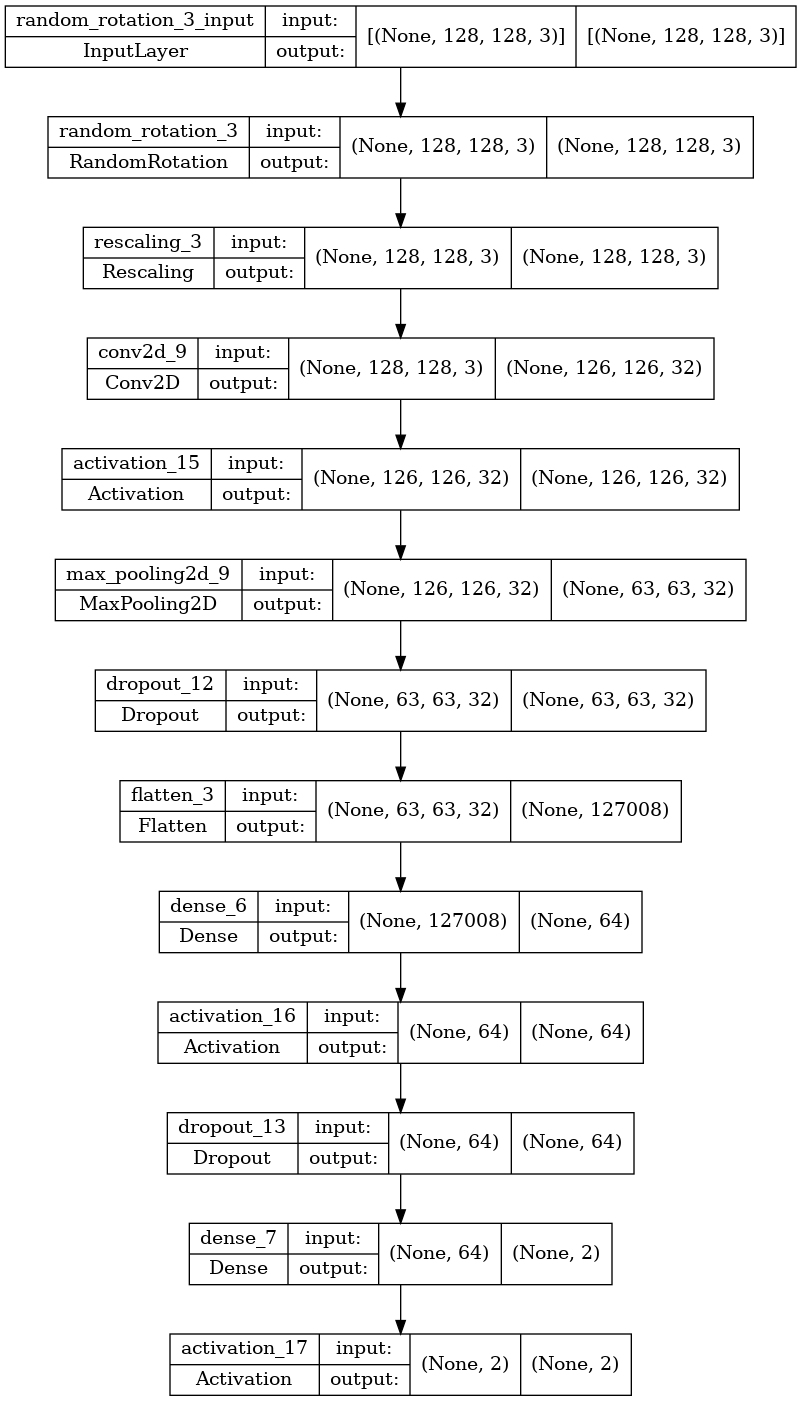

In [34]:
plot_model(model, show_shapes=True)

### model 2 (convolution 3회)

In [24]:
ADJUSTED_IMAGE_SIZE = 128
input_shape = (ADJUSTED_IMAGE_SIZE, ADJUSTED_IMAGE_SIZE, 3)
num_classes = y_train.shape[1]

model = Sequential()
model.add(RandomRotation(factor=0.15))
model.add(Rescaling(1/255))
model.add(Conv2D(32, (3, 3), input_shape=input_shape)) # (3, 3) - conv kernel

model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(32, (3, 3)))

model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3)))

model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0005),
              metrics=['accuracy'])
with tf.device("/device:GPU:0"):
    history = model.fit(X_train,y_train,epochs = 50,validation_data = (X_test,y_test),batch_size = 8,
                        callbacks=[EarlyStopping(monitor = "val_loss", patience = 10, restore_best_weights = True),
                        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')])

fcl_loss, fcl_accuracy = model.evaluate(X_test, y_test, verbose=1) # , fcl_f1
print('Test loss:', fcl_loss)
print('Test accuracy:', fcl_accuracy)
# print('Test F1:', fcl_f1)

df = pd.DataFrame({"pred": np.argmax(model.predict(X_test), axis=1), "true": np.argmax(y_test, axis=1)})
print(classification_report(df["true"], df["pred"]))

Epoch 1/50
3023/3023 [==============================] - 26s 8ms/step - loss: 0.5461 - accuracy: 0.7221 - val_loss: 0.4974 - val_accuracy: 0.7668 - lr: 5.0000e-04
Epoch 2/50
3023/3023 [==============================] - 25s 8ms/step - loss: 0.5009 - accuracy: 0.7605 - val_loss: 0.4804 - val_accuracy: 0.7696 - lr: 5.0000e-04
Epoch 3/50
3023/3023 [==============================] - 24s 8ms/step - loss: 0.4896 - accuracy: 0.7699 - val_loss: 0.4727 - val_accuracy: 0.7797 - lr: 5.0000e-04
Epoch 4/50
3023/3023 [==============================] - 25s 8ms/step - loss: 0.4823 - accuracy: 0.7740 - val_loss: 0.4758 - val_accuracy: 0.7752 - lr: 5.0000e-04
Epoch 5/50
3023/3023 [==============================] - 24s 8ms/step - loss: 0.4772 - accuracy: 0.7747 - val_loss: 0.4707 - val_accuracy: 0.7782 - lr: 5.0000e-04
Epoch 6/50
3023/3023 [==============================] - 25s 8ms/step - loss: 0.4783 - accuracy: 0.7768 - val_loss: 0.4699 - val_accuracy: 0.7812 - lr: 5.0000e-04
Epoch 7/50
3023/3023 [======

- 모델 layer 시각화

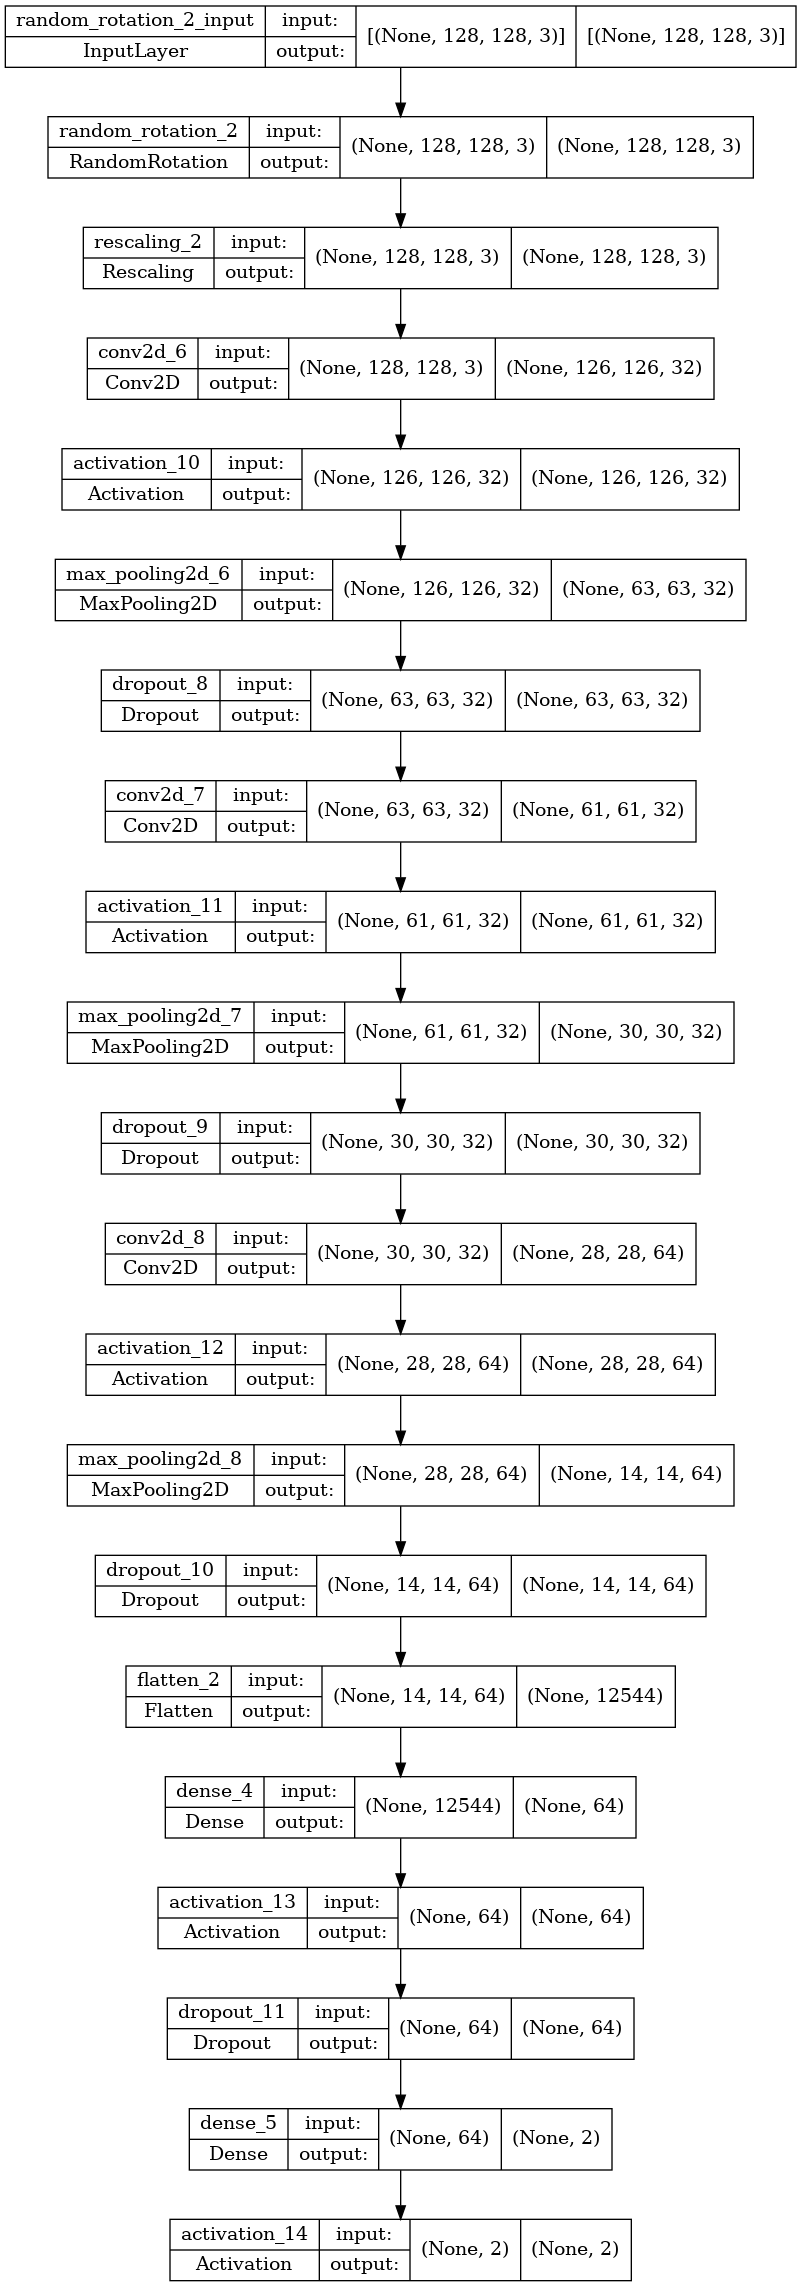

In [25]:
plot_model(model, show_shapes=True)

- model 2의 학습동안 진행된 train set의 accuracy, loss 변화 시각화

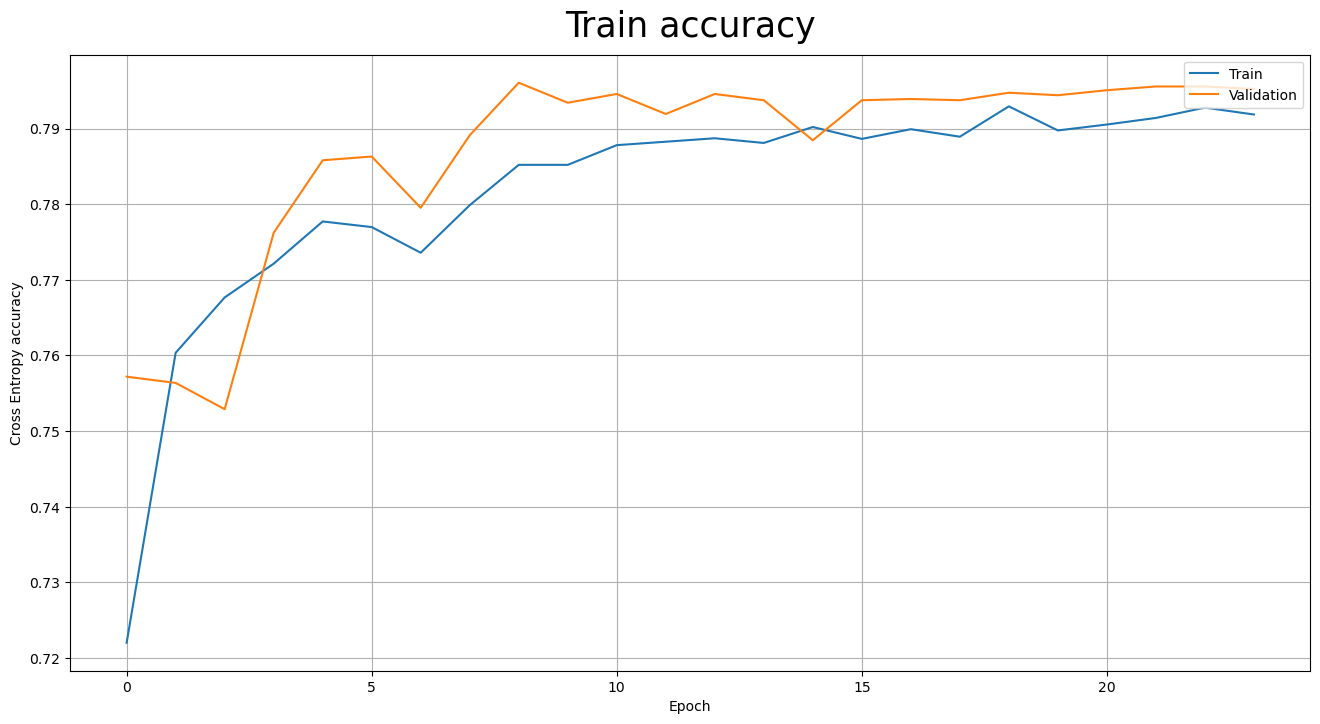

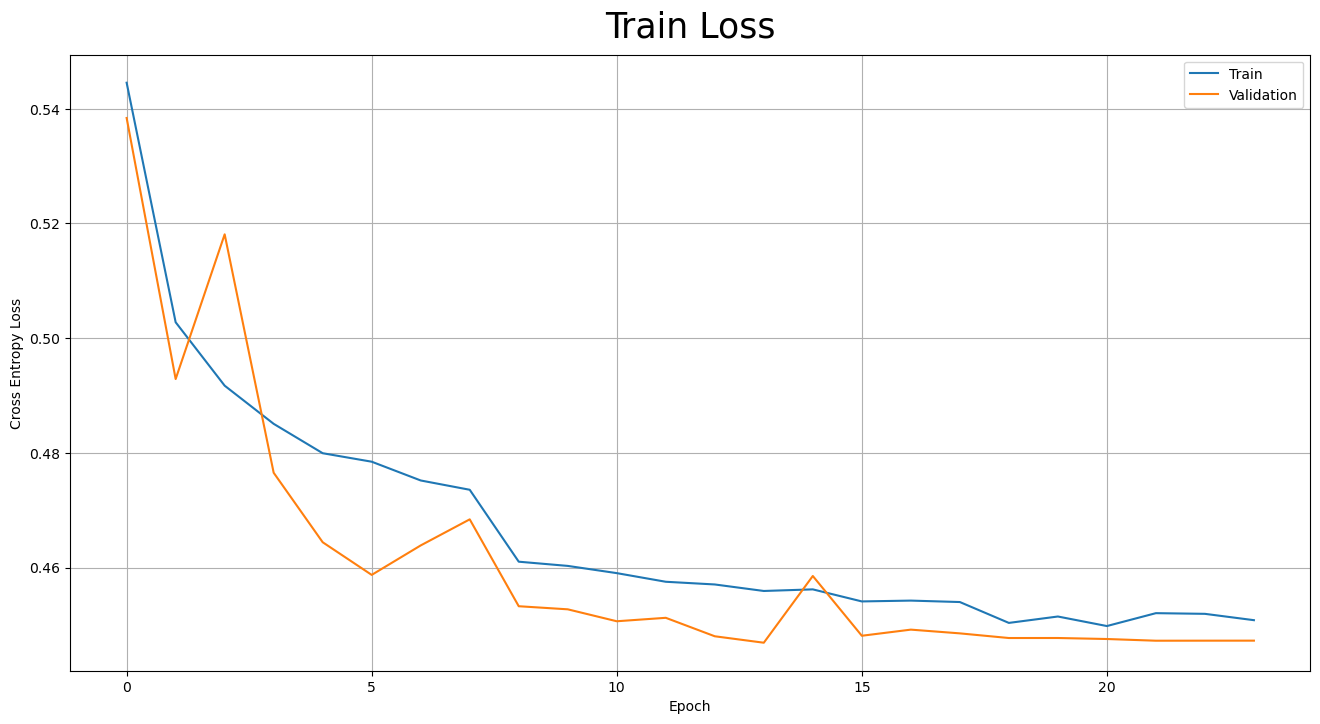

In [21]:
plt.figure(figsize=(16, 8))

plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.ylabel('Cross Entropy accuracy')
plt.xlabel('Epoch')
plt.title('Train accuracy', pad=13, fontsize=25)
plt.legend(loc='upper right')
plt.grid(000.1)

plt.show()


plt.figure(figsize=(16, 8))

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Epoch')
plt.title('Train Loss', pad=13, fontsize=25)
plt.legend(loc='upper right')
plt.grid(000.1)

plt.show()

- 기존 사전 학습된 모델을 기반으로 transfer-learning model 구축
- resnet50 모델의 imagenet을 통해 학습한 가중치 등을 사용하는 transfer learning 모델링
- Data augmentation (random fliping) 을 통한 성능 향상

### model 3 (transfer learning)

In [38]:
from tensorflow.keras.applications.resnet50 import ResNet50

base_model = ResNet50(include_top=False, input_shape = (128, 128 ,3), weights = 'imagenet')

for layer in base_model.layers:
      layer.trainable = False

augment = Sequential([

    RandomRotation(0.15)
], name='AugmentationLayer')

inputs = Input(shape = input_shape, name='inputLayer')
x = augment(inputs)
pretrain_out = base_model(x, training = False)
x = Flatten()(pretrain_out)
x = Dense(64, activation='relu')(x)
x = Dense(y_train.shape[1], name='outputLayer')(x)
outputs = Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x)
model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=Adam(learning_rate=0.0005), # 
                   loss=losses.categorical_crossentropy, 
                   metrics=['accuracy']) # ,f1_m

history = model.fit(X_train, 
                         y_train, 
                         batch_size=16, 
                         epochs=60, 
                         validation_data=(X_test, y_test),
                         callbacks=[
                             EarlyStopping(monitor = "val_loss", patience = 15, 
                                           restore_best_weights = True, mode='min'),
                             ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
                    ]
                        )
fcl_loss, fcl_accuracy  = model.evaluate(X_test, y_test, verbose=1) # fcl_f1
print('Test loss:', fcl_loss)
print('Test accuracy:', fcl_accuracy)
# print('Test F1:', fcl_f1)


df = pd.DataFrame({"pred": np.argmax(model.predict(X_test), axis=1), "true": np.argmax(y_test, axis=1)})
print(classification_report(df["true"], df["pred"]))

94781440/94765736 [==============================] - 9s 0us/step
Epoch 1/60
1512/1512 [==============================] - 40s 25ms/step - loss: 0.4712 - accuracy: 0.7784 - val_loss: 0.4335 - val_accuracy: 0.7989 - lr: 5.0000e-04
Epoch 2/60
1512/1512 [==============================] - 36s 24ms/step - loss: 0.4247 - accuracy: 0.8005 - val_loss: 0.4265 - val_accuracy: 0.7989 - lr: 5.0000e-04
Epoch 3/60
1512/1512 [==============================] - 35s 23ms/step - loss: 0.4171 - accuracy: 0.8022 - val_loss: 0.4286 - val_accuracy: 0.8005 - lr: 5.0000e-04
Epoch 4/60
1512/1512 [==============================] - 36s 24ms/step - loss: 0.4108 - accuracy: 0.8061 - val_loss: 0.4255 - val_accuracy: 0.8050 - lr: 5.0000e-04
Epoch 5/60
1512/1512 [==============================] - 36s 24ms/step - loss: 0.4057 - accuracy: 0.8087 - val_loss: 0.4182 - val_accuracy: 0.8071 - lr: 5.0000e-04
Epoch 6/60
1512/1512 [==============================] - 35s 23ms/step - loss: 0.3984 - accuracy: 0.8130 - val_loss: 0.42

In [39]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']      

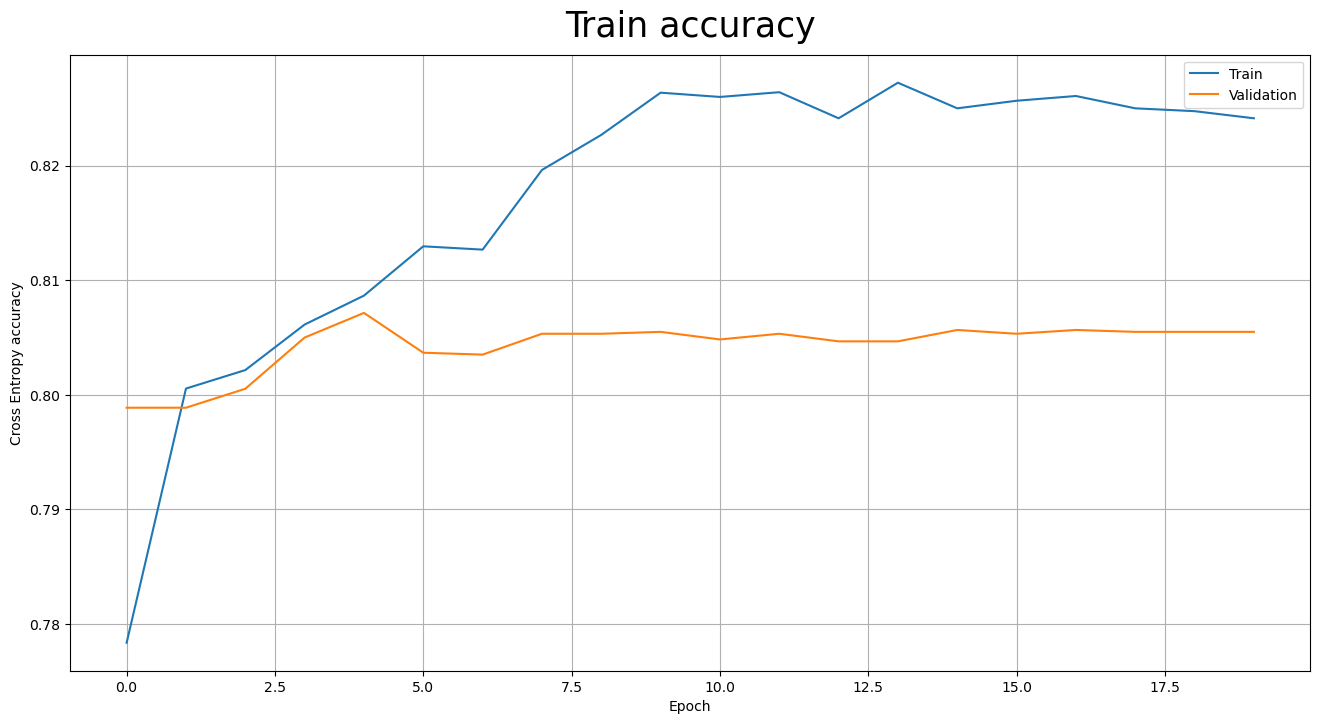

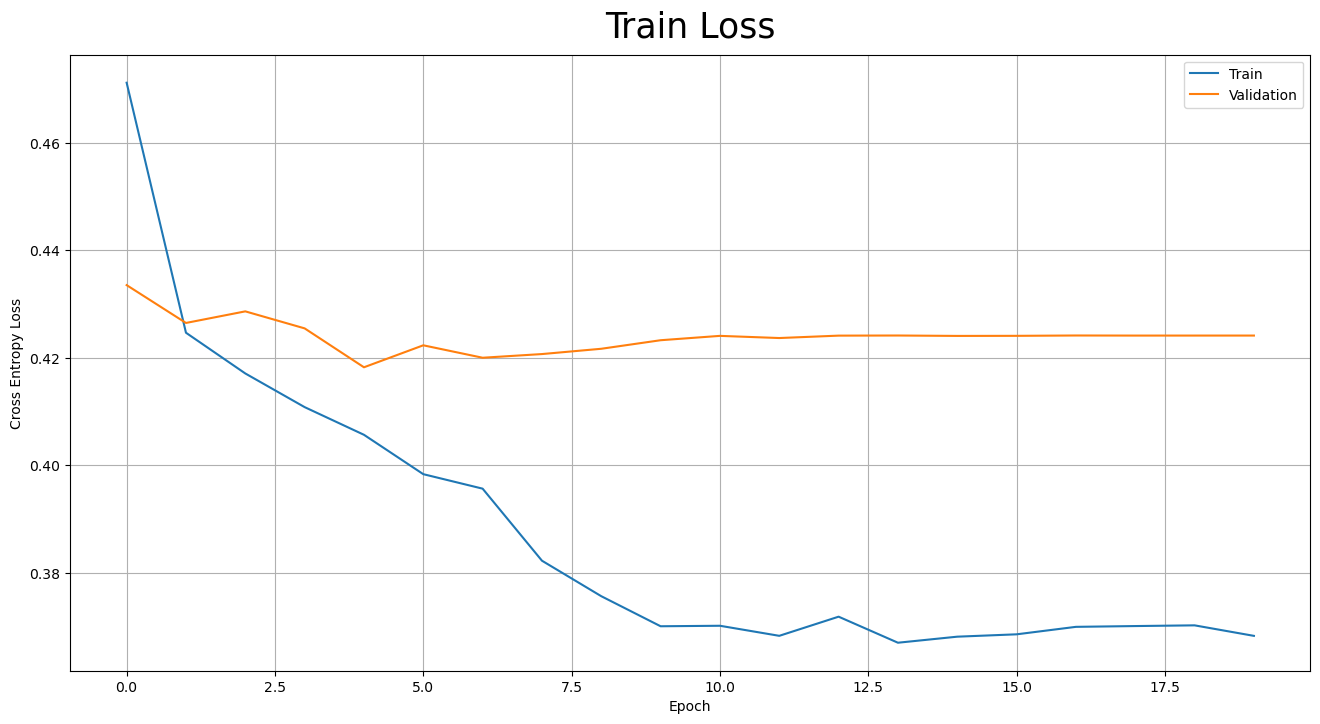

In [40]:
plt.figure(figsize=(16, 8))

plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.ylabel('Cross Entropy accuracy')
plt.xlabel('Epoch')
plt.title('Train accuracy', pad=13, fontsize=25)
plt.legend(loc='upper right')
plt.grid(000.1)

plt.show()


plt.figure(figsize=(16, 8))

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Epoch')
plt.title('Train Loss', pad=13, fontsize=25)
plt.legend(loc='upper right')
plt.grid(000.1)

plt.show()

- 자신만의 독창적인 아키텍쳐를 통한 폐렴 분류 성능 향상
- resnet 이 아닌 Inception, EfficientNet, VGG16 등의 다른 사전학습 모델을 사용하여 성능 비교